# Descrption

The notebook runs the Mock3 pipeline using stitched data (OHLCV and bid/ask).

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import core.config as cconfig
import core.finance.bid_ask as cfibiask
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import dataflow_amp.pipelines.mock3.mock3_pipeline as dtfapmmopi
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.ccxt.data.client as icdcl
import im_v2.common.universe as ivcu
import market_data.market_data_example as mdmadaex

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-57407bf9-fd5a-461e-aa26-e2bd27c3ebe4.json'
INFO  # Git
  branch_name='CmTask7174_Centralize_get_bid_ask_columns_by_level'
  hash='ac2b791a1'
  # Last commits:
    * ac2b791a1 tamriq   CmTask7174: fix linter for mock3_forecast_system_example          (49 seconds ago) Wed Feb 14 19:24:27 2024  (HEAD -> CmTask7174_Centralize_get_bid_ask_columns_by_level)
    * 9a93a7429 tamriq   CmTask7174: linter fix                                            (   4 hours ago) Wed Feb 14 15:25:27 2024           
    * 51b0000cc tamriq   CmTask7174: fix typo                                              (   4 hours ago) Wed Feb 14 15:15:35 2024           
# Machine info
  system=Linux
  node name=74fe9314c391
  release=5.15.0-1052-aws
  version=#57~20.04.1-Ubuntu SMP Mon Jan 15 17:04:56 UTC 2024
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpufreq(current=2499.998, min=0.0, max=

# Config

In [4]:
bid_ask_level = 1
_LOG.info("Order book depth=%s", bid_ask_level)

INFO  Order book depth=1


In [5]:
trade_universe_version = "v7.5"
_LOG.info("Trade universe version=%s", trade_universe_version)

INFO  Trade universe version=v7.5


In [6]:
config = {
    "universe": {
        "vendor": "CCXT",
        "version": trade_universe_version,
        "mode": "trade",
    },
    "start_timestamp": pd.Timestamp("2023-09-11T00:00:00", tz="UTC"),
    "end_timestamp": pd.Timestamp("2023-09-11T04:00:00", tz="UTC"),
    "ohlcv_market_data": {
        "ohlcv_im_client_config": {
            # Download universe version.
            "download_universe_version": "v7_3",
            "dataset": "ohlcv",
            "contract_type": "futures",
            # Data snapshot is not applicable for data version = "v3".
            "data_snapshot": "",
            "universe_version": trade_universe_version,
            # Data currently residing in the test bucket
            "root_dir": "s3://cryptokaizen-data.preprod/v3/",
            "partition_mode": "by_year_month",
            "version": "v1_0_0",
            "tag": "downloaded_1min",
            "aws_profile": "ck",
        },
        "ts_col_name": "timestamp",
        "columns": None,
        "column_remap": None,
        "wall_clock_time": pd.Timestamp("2100-01-01T00:00:00+00:00"),
        "filter_data_mode": "assert",
    },
    "bid_ask_market_data": {
        "bid_ask_im_client_config": {
            # Download universe version.
            "download_universe_version": "v7",
            "dataset": "bid_ask",
            "contract_type": "futures",
            # Data snapshot is not applicable for data version = "v3".
            "data_snapshot": "",
            "universe_version": trade_universe_version,
            # Data currently residing in the test bucket
            "root_dir": "s3://cryptokaizen-data.preprod/v3/",
            "partition_mode": "by_year_month",
            "version": "v1_0_0",
            "tag": "resampled_1min",
            "aws_profile": "ck",
        },
        "ts_col_name": "timestamp",
        # TODO(Grisha): for some reason the current filtering mechanism filters out `asset_ids` which
        # makes it impossible to stitch the 2 market data dfs. So adding the necessary columns manually.
        "columns": cfibiask.get_bid_ask_columns_by_level(bid_ask_level)
        + ["asset_id", "full_symbol", "start_ts", "knowledge_timestamp"],
        "column_remap": None,
        "wall_clock_time": pd.Timestamp("2100-01-01T00:00:00+00:00"),
        "filter_data_mode": "assert",
    },
    "stitched_market_data": {
        "ts_col_name": "timestamp",
        "columns": None,
        "column_remap": None,
        # TODO(Grisha): check why it fails when the mode is `assert`.
        "filter_data_mode": "warn_and_trim",
    },
    "historical_data_source": {
        "nid": "read_data",
        "ts_col_name": "end_ts",
        "multiindex_output": True,
        "columns_to_remove": ["start_ts", "full_symbol"],
    },
}
config = cconfig.Config().from_dict(config)
print(config)

universe: 
  vendor: CCXT
  version: v7.5
  mode: trade
start_timestamp: 2023-09-11 00:00:00+00:00
end_timestamp: 2023-09-11 04:00:00+00:00
ohlcv_market_data: 
  ohlcv_im_client_config: 
    download_universe_version: v7_3
    dataset: ohlcv
    contract_type: futures
    data_snapshot: 
    universe_version: v7.5
    root_dir: s3://cryptokaizen-data.preprod/v3/
    partition_mode: by_year_month
    version: v1_0_0
    tag: downloaded_1min
    aws_profile: ck
  ts_col_name: timestamp
  columns: None
  column_remap: None
  wall_clock_time: 2100-01-01 00:00:00+00:00
  filter_data_mode: assert
bid_ask_market_data: 
  bid_ask_im_client_config: 
    download_universe_version: v7
    dataset: bid_ask
    contract_type: futures
    data_snapshot: 
    universe_version: v7.5
    root_dir: s3://cryptokaizen-data.preprod/v3/
    partition_mode: by_year_month
    version: v1_0_0
    tag: resampled_1min
    aws_profile: ck
  ts_col_name: timestamp
  columns: ['level_1.bid_price.open', 'level_1.bid

# HistoricalDataSource

In [7]:
as_full_symbol = True
full_symbols = ivcu.get_vendor_universe(
    config["universe"]["vendor"],
    config["universe"]["mode"],
    version=config["universe"]["version"],
    as_full_symbol=as_full_symbol,
)
# Use only a subset for the demonstration.
_LOG.info("Full symbols=%s", full_symbols)

INFO  Full symbols=['binance::BTC_USDT', 'binance::ETH_USDT']


In [8]:
asset_ids = list(ivcu.build_numerical_to_string_id_mapping(full_symbols).keys())
_LOG.info("Asset ids=%s", asset_ids)

INFO  Asset ids=[1467591036, 1464553467]


In [9]:
ohlcv_im_client = icdcl.CcxtHistoricalPqByTileClient(
    **config["ohlcv_market_data"]["ohlcv_im_client_config"]
)
ohlcv_market_data = mdmadaex.get_HistoricalImClientMarketData_example1(
    ohlcv_im_client,
    asset_ids,
    config["ohlcv_market_data"]["columns"],
    config["ohlcv_market_data"]["column_remap"],
    wall_clock_time=config["ohlcv_market_data"]["wall_clock_time"],
    filter_data_mode=config["ohlcv_market_data"]["filter_data_mode"],
)

In [10]:
bid_ask_im_client = icdcl.CcxtHistoricalPqByTileClient(
    **config["bid_ask_market_data"]["bid_ask_im_client_config"]
)
bid_ask_market_data = mdmadaex.get_HistoricalImClientMarketData_example1(
    bid_ask_im_client,
    asset_ids,
    config["bid_ask_market_data"]["columns"],
    config["bid_ask_market_data"]["column_remap"],
    wall_clock_time=config["bid_ask_market_data"]["wall_clock_time"],
    filter_data_mode=config["bid_ask_market_data"]["filter_data_mode"],
)

In [11]:
stitched_mdata = mdmadaex.get_HorizontalStitchedMarketData_example1(
    bid_ask_market_data,
    ohlcv_market_data,
    asset_ids,
    config["stitched_market_data"]["columns"],
    config["stitched_market_data"]["column_remap"],
    filter_data_mode=config["stitched_market_data"]["filter_data_mode"],
)

In [12]:
data_source_node = dtfsys.HistoricalDataSource(
    config["historical_data_source"]["nid"],
    stitched_mdata,
    config["historical_data_source"]["ts_col_name"],
    config["historical_data_source"]["multiindex_output"],
    col_names_to_remove=config["historical_data_source"]["columns_to_remove"],
)
data_source_node.set_fit_intervals(
    [(config["start_timestamp"], config["end_timestamp"])]
)

# Build and run the DAG

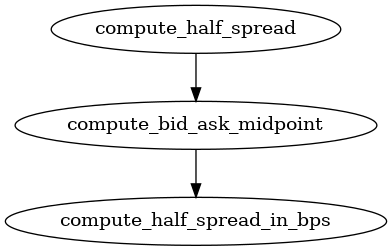

In [13]:
dag_builder = dtfapmmopi.Mock3_DagBuilder()
dag = dag_builder.get_fully_built_dag()
dtfcore.draw(dag)

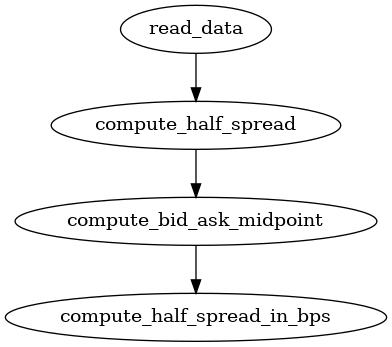

In [14]:
dag.insert_at_head(data_source_node)
dtfcore.draw(dag)

In [15]:
dag_df_out = dag.run_leq_node("compute_half_spread_in_bps", "fit")["df_out"]
dag_df_out.head(5)

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


half_spread_in_bps            bid_ask_midpoint            half_spread                 close                  high                         knowledge_timestamp                                  level_1.ask_price.close            level_1.ask_price.high            level_1.ask_price.low            level_1.ask_price.mean               level_1.ask_price.open            level_1.ask_size.close            level_1.ask_size.max            level_1.ask_size.mean            level_1.ask_size.min            level_1.ask_size.open            level_1.bid_price.close            level_1.bid_price.high            level_1.bid_price.low            level_1.bid_price.mean               level_1.bid_price.open            level_1.bid_size.close            level_1.bid_size.max            level_1.bid_size.mean            level_1.bid_size.min            level_1.bid_size.open                   low                  open                volume           
                                  1464553467 1467591036       1464553467 1467591036  1464553467 1467591036 1464553467 1467591036 1464553467 1467591036                       1464553467                       1467591036              1464553467 1467591036             1464553467 1467591036            1464553467 1467591036             1464553467    1467591036             1464553467 1467591036             1464553467 1467591036           1464553467 1467591036            1464553467 1467591036           1464553467 1467591036            1464553467 1467591036              1464553467 1467591036             1464553467 1467591036            1464553467 1467591036             1464553467    1467591036             1464553467 1467591036             1464553467 1467591036           1464553467 1467591036            1464553467 1467591036           1464553467 1467591036            1464553467 1467591036 1464553467 1467591036 1464553467 1467591036 1464553467 1467591036
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2023-09-10 20:00:00-04:00           0.030932   0.019358         1616.465   25828.45       0.005       0.05    1616.47    25828.4    1616.87    25830.5 2023-11-30 21:37:09.705931+00:00 2023-11-30 21:37:09.705931+00:00                 1616.47    25828.5                1616.88    25830.5               1616.47    25828.5            1616.673821  25829.231837                1616.88    25829.0                 49.234      9.031              164.987     25.098             90.262045   9.467396                5.071      0.039                92.699      1.766                 1616.46    25828.4                1616.87    25830.4               1616.46    25828.4            1616.663780  25829.131837                1616.87    25828.9                 39.984      4.178               99.315     24.253             22.051272   8.006967                0.069      0.051                 1.947     23.794    1616.46    25828.4    1616.87    25829.0    392.478     35.063
2023-09-10 20:01:00-04:00           0.030921   0.019353         1617.035   25835.75       0.005       0.05    1617.04    25835.7    1617.22    25835.8 2023-11-30 21:37:31.833535+00:00 2023-11-30 21: